In [13]:
from typing import Iterable

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary

from segmentation_models_pytorch import DeepLabV3Plus

from lightning import Trainer, seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger

from source.dataset import ImageDatasetForSegmentation
from source.segmentation_model import SegmentationModel

In [2]:
seed_everything(42)

Seed set to 42


42

In [3]:
DS_PARAMS = {
    'height': 256,
    'width': 256,
    'mean': (0.585, 0.466, 0.445),
    'std': (0.224, 0.208, 0.198),
}

train_ds = ImageDatasetForSegmentation('./data/train', **DS_PARAMS)
val_ds = ImageDatasetForSegmentation('./data/val', is_train=False, **DS_PARAMS)
test_ds = ImageDatasetForSegmentation('./data/test', is_train=False, **DS_PARAMS)

len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 69/69 [00:05<00:00, 12.53it/s]


(503, 67, 69)

In [4]:
def plot_image_grid(images: Iterable[np.ndarray]) -> None:
    fig, axs = plt.subplots(1, len(images), gridspec_kw={'wspace': 0, 'hspace': 0})

    for ax, image in zip(axs, images):
        ax.imshow(image)
        ax.axis('off')

    fig.show()

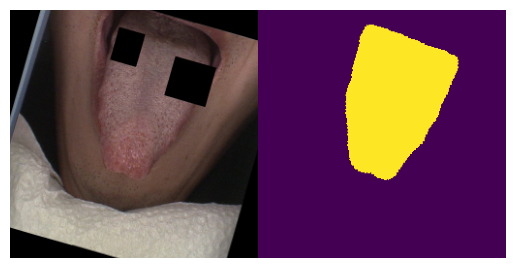

In [5]:
image, mask = train_ds[42].values()
plot_image_grid([train_ds.restore_image(image), mask])

In [6]:
DL_PARAMS = {'batch_size': 16, 'num_workers': 24}

train_dl = DataLoader(train_ds, shuffle=True, **DL_PARAMS)
val_dl = DataLoader(val_ds, **DL_PARAMS)
test_dl = DataLoader(test_ds, **DL_PARAMS)

In [7]:
for batch in train_dl:
    break

batch['image'].shape, batch['mask'].shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 256, 256]))

In [38]:
model = SegmentationModel(DeepLabV3Plus(encoder_name='efficientnet-b5'), lr=5e-5)
summary(model, input_size=batch['image'].shape)

Layer (type:depth-idx)                                       Output Shape              Param #
SegmentationModel                                            [5, 256, 256]             --
├─DeepLabV3Plus: 1-1                                         [5, 1, 256, 256]          --
│    └─EfficientNetEncoder: 2-1                              [5, 3, 256, 256]          1,052,672
│    │    └─Conv2dStaticSamePadding: 3-1                     [5, 48, 128, 128]         1,296
│    │    └─BatchNorm2d: 3-2                                 [5, 48, 128, 128]         96
│    │    └─MemoryEfficientSwish: 3-3                        [5, 48, 128, 128]         --
│    │    └─ModuleList: 3-4                                  --                        27,286,720
│    └─DeepLabV3PlusDecoder: 2-2                             [5, 256, 64, 64]          --
│    │    └─Sequential: 3-5                                  [5, 256, 16, 16]          1,068,288
│    │    └─UpsamplingBilinear2d: 3-6                        [5, 256, 

In [9]:
logger = MLFlowLogger('segmentation-model')
early_stopping = EarlyStopping(monitor='validation_jaccard', patience=10, mode='max')
checkpoint_callback = ModelCheckpoint(
    monitor='validation_jaccard',
    dirpath='./models/',
    filename='{epoch}-{step}-{validation_jaccard:.4f}',
    mode='max',
)
trainer = Trainer(
    logger=logger,
    callbacks=[early_stopping, checkpoint_callback],
    max_epochs=100,
    # val_check_interval=0.5,
    log_every_n_steps=16,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dl, val_dl)

In [11]:
trainer.test(model, test_dl, ckpt_path=checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at /home/ArtemF42/space/hse-oral-cancer/models/epoch=69-step=2240-validation_jaccard=0.9274.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ArtemF42/space/hse-oral-cancer/models/epoch=69-step=2240-validation_jaccard=0.9274.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_dice           0.9394907355308533
      test_jaccard          0.8856128454208374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_jaccard': 0.8856128454208374, 'test_dice': 0.9394907355308533}]

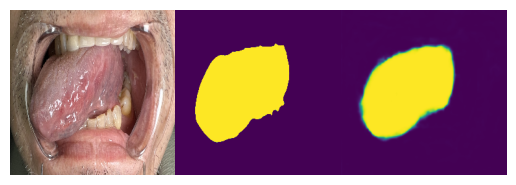

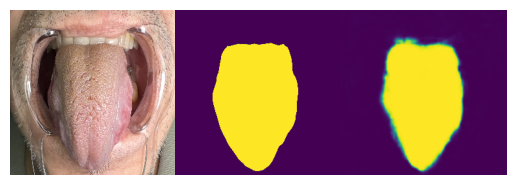

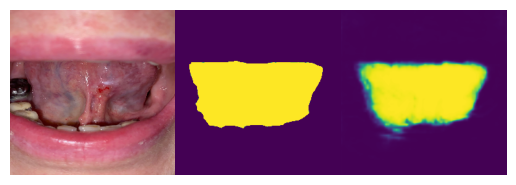

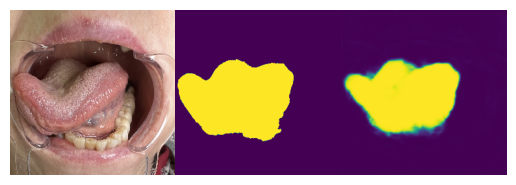

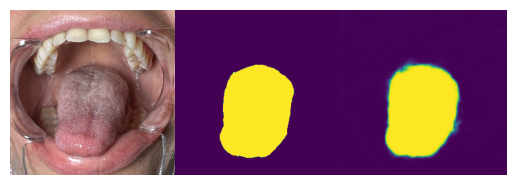

In [37]:
model = SegmentationModel.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    model=DeepLabV3Plus(encoder_name='efficientnet-b5'),
).cpu()

for batch in test_dl:
    images, true_masks = batch['image'], batch['mask']

with torch.no_grad():
    pred_masks = nn.functional.sigmoid(model(images))

MAX_PLOTS = 8

for i, (image, true_mask, pred_mask) in enumerate(zip(images, true_masks, pred_masks)):
    if i < MAX_PLOTS:
        plot_image_grid(
            [test_ds.restore_image(image), true_mask.numpy(), pred_mask.numpy()]
        )
    else:
        break